In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import collections
import functools
import itertools
import os
import pathlib
import sys
import textwrap

import datasets
import matplotlib.pyplot as plt
import numpy as np
import re
from rich.jupyter import print
import rich.pretty
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import transformers
import tqdm

sys.path.append("..")
import bert_utils
import constants
import retrievers
import tf_utils
import utils

print(f"{np.__version__ = }")
print(f"{tf.__version__ = }")
rich.pretty.install()

In [19]:
# Arguments

NP_SEED = 0
NUM_SUBSET = 10000
USE_REMOTE = False
BLOCKS_PATH_LOCAL = "../../data/realm_blocks/blocks.tfr"
assert os.path.exists(BLOCKS_PATH_LOCAL)

In [20]:
# Prepare different HuggingFace objects that will definitely be needed.

eli5 = datasets.load_dataset("kilt_tasks", "eli5")
gpt2_tokenizer = transformers.GPT2TokenizerFast.from_pretrained("gpt2-xl")
print(f"Dataset split keys: {list(eli5.keys())}")

Reusing dataset kilt_tasks (/Users/jules/.cache/huggingface/datasets/kilt_tasks/eli5/1.0.0/c3ef4ce7d18c05d55d7481fa79f9a9234deb0b1696c062e9e05370eb36355cae)


Dataset split keys: [ 'train' , 'validation' , 'test' ]

In [21]:
# Load the configuration file for the retriever. This tells us where the reference file is and how many
# entries it has.

retriever_config = tf_utils.REALMConfig(
      **utils.from_json_file("../configs/retriever_configs/open_source.json")
)
vars(retriever_config)

{ 
 'query_embedder_path' : 'gs://realm-data/cc_news_pretrained/embedder' ,
 'text_records' : 'gs://orqa-data/enwiki-20181220/blocks.tfr' ,
 'num_block_records' : 13353718 ,
 'description' : 'ORQA blocks text and REALM query embedder' 
 }

In [22]:
# Load the reference text DB.
# This part takes a really long time.
if USE_REMOTE:
    print("Using remote blocks.tfr.")
    block_records_path = retriever_config.text_records
else:
    print("Using localblocks.tfr.")
    block_records_path = BLOCKS_PATH_LOCAL
    
num_block_records = retriever_config.num_block_records

print("tf.data.TFRecordDataset")
blocks_dataset = tf.data.TFRecordDataset(
    block_records_path,
   # Value taken from the REALM
   # code.
   buffer_size=512 * 1024 * 1024,
)

print("blocks_dataset.batch")
blocks_dataset = blocks_dataset.batch(num_block_records, drop_remainder=False)

print("tf.data.experimental.get_single_element")
blocks = tf.data.experimental.get_single_element(blocks_dataset)

In [23]:
# Convert the DB to numpy

np.random.seed(NP_SEED)
subset = tf.constant(np.random.permutation(NUM_SUBSET))
print("Creating subset")
tf_blocks = tf.gather(blocks, subset)

print("Converting to tf")
np_blocks_subset = tf_blocks.numpy()

Creating subset

Converting to tf

In [24]:
# Extract the lengths of a number of entries

print(subset.shape)

lengths = []
for line in tqdm.tqdm(np_blocks_subset):
    lengths.append(len(gpt2_tokenizer(line.decode())["input_ids"]))

( 10000 , )

100%|██████████| 10000/10000 [00:11<00:00, 903.52it/s]


In [25]:
# Compute maximum lengths of a number of centiles
# This is really quick and dirty, inefficient code.

counter = collections.Counter(lengths)
by_len = sorted(counter.items(), key=lambda pair: pair[0])
maxes = []
for max_percentage in (.8, .85, .875, .9, .925, .95, .975):
    accum = {}
    accum_v = 0
    for len_, count in by_len:
        if accum_v < max_percentage:
            accum_v += count / len(lengths)
            accum[len_] = accum_v
    max_ = max(accum.items(), key=lambda x: x[0])
    maxes.append(max_)
    print(max_)

( 275 , 0.8090999999999999 )

( 278 , 0.8549999999999999 )

( 280 , 0.8792999999999999 )

( 282 , 0.9033999999999999 )

( 285 , 0.9323999999999998 )

( 288 , 0.9546999999999999 )

( 293 , 0.9770999999999997 )

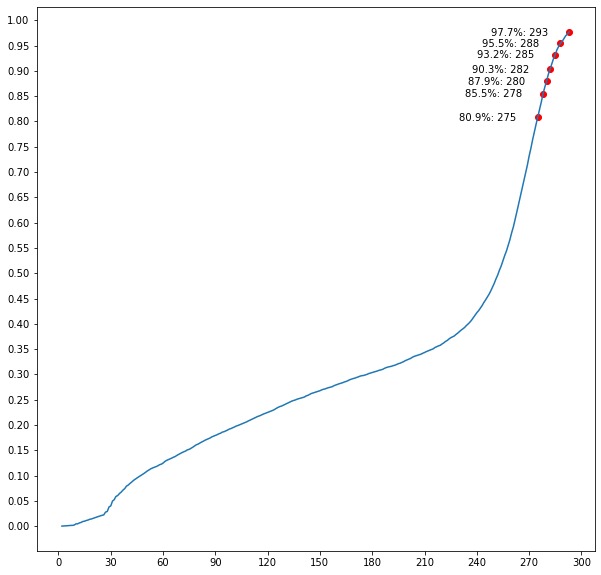

In [26]:
# We plot the results.

plt.figure(figsize=(10, 10))
plt.plot(accum.keys(), accum.values())
for x, y in maxes:
    plt.scatter(x=(x,), y=(y,), color="red")
plt.yticks(np.linspace(0, 1, 21))
plt.xticks(np.linspace(0, 300, 11))
for x, y in maxes:
    plt.text(x - 45, y- 0.0075, f"{y:0.1%}: {x}", size=10)